In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [2]:
device= 'cuda'

In [3]:
df= pd.read_excel('Temparature_Mymensingh.xlsx')
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [4]:
features = ['DayOfYear', 'Month', 'Year','Temp']
target = ['Temp']

### Scaling

In [5]:
scaler_x=MinMaxScaler()
scaler_y=MinMaxScaler()
x_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[target]) # works with 2D array

### Sequencing data

In [6]:
def sequence(x,y,length):  ## this will help to predict the next one
    xs,ys= [], []
    for i in range(len(x)- length):
        xs.append(x[i:i+length])
        ys.append(y[i+length])
    
    return np.array(xs), np.array(ys)

seq_length=25
X,y= sequence(x=x_scaled,y=y_scaled,length=seq_length)

### Spliting data

In [7]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.20, shuffle=False)

# now converting to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
len(X_train),len(X_test)

(7577, 1895)

### Using DataLoader

In [8]:
from torch.utils.data import DataLoader, TensorDataset

batch_size=32

train_data= TensorDataset(X_train,y_train)
test_data= TensorDataset(X_test,y_test)

train_data_loader=DataLoader(batch_size=batch_size,
                             shuffle=True,
                             dataset=train_data)

test_data_loader=DataLoader(batch_size=batch_size,
                            shuffle=False,
                            dataset=test_data)

### Making the model

In [9]:
class modelV1(nn.Module):
    def __init__(self, input_size,hidden_unit,num_layers):
        super(modelV1,self).__init__()
        self.lstm=nn.LSTM(input_size,
                          hidden_unit,
                          num_layers,
                          batch_first=True,
                          dropout=0.2,)
        self.fc1 = nn.Linear(hidden_unit, 128)
        self.relu = nn.ReLU()
        self.fc2=nn.Linear(128,64)
        self.relu2=nn.ReLU()
        self.fc3 = nn.Linear(64, 1) 
    
    def __call__(self, x):
        out,_=self.lstm(x)
        out=self.relu2(self.fc2(self.relu(self.fc1(out[:,-1,:]))))
        out=self.fc3(out)
        return out

In [10]:
# model , loss , optimizer
model_0=torch.compile(modelV1(input_size=4,hidden_unit=512,num_layers=9).to(device))
loss_fn= nn.MSELoss()
optimizer=torch.optim.Adam(model_0.parameters(), lr=0.0001)

In [11]:
# Training
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    #train
    model.train()
    train_loss=0
    for batch, (X,y) in enumerate(data_loader):
        X,y=X.to(device),y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss +=loss

    print (f'Train loss: {train_loss: .3f}')
    return train_loss


In [12]:
# Testing
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
    
    model.eval()
    test_loss=0
    with torch.inference_mode():
        for X,y in data_loader:
            X,y=X.to(device),y.to(device)

            test_pred=model(X)
            loss=loss_fn(test_pred,y)

            test_loss +=loss

    print(f'Test Loss: {test_loss: .3f}')
    return test_loss

### Early Stopping

In [13]:
class EarlyStoppingByLoss:
    def __init__(self, patience:int, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_epoch = -1  # Track the epoch of the best model

    def __call__(self, test_loss, model, epoch):
        if test_loss < self.best_loss:
            self.best_loss = test_loss
            self.counter = 0
            self.best_epoch = epoch
            torch.save(model.state_dict(), 'checkpoint.pt')
            if self.verbose:
                print(f"New best test loss: {test_loss:.4f} at epoch {epoch+1}. Saving model.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in test loss for {self.counter} epoch(s).")
            if self.counter >= self.patience:
                if self.verbose:
                    print(f"Early stopping: No improvement in test loss for {self.patience} epochs.")
                self.early_stop = True

In [14]:
# Training testing data
from tqdm.auto import tqdm
epochs=200
early_stopping=EarlyStoppingByLoss(patience=20,verbose=True)
for epoch in tqdm(range(epochs)):
    print(f'\nEpoch: {epoch}\n------')

    train_loss=train_step(model=model_0,
                          data_loader=train_data_loader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          device=device)
    test_loss=test_step(model=model_0,
                        data_loader=test_data_loader,
                        loss_fn=loss_fn,
                        device=device)
     # Early stopping step
    early_stopping(test_loss, model_0, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

best_epoch = early_stopping.best_epoch
print(f"Best model saved at epoch {best_epoch+1}")

# Restore best model
model_0.load_state_dict(torch.load('checkpoint.pt'))

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 0
------
Train loss:  15.106
Test Loss:  2.227
New best test loss: 2.2269 at epoch 1. Saving model.

Epoch: 1
------
Train loss:  7.349
Test Loss:  2.072
New best test loss: 2.0720 at epoch 2. Saving model.

Epoch: 2
------
Train loss:  7.307
Test Loss:  2.146
No improvement in test loss for 1 epoch(s).

Epoch: 3
------
Train loss:  7.310
Test Loss:  2.080
No improvement in test loss for 2 epoch(s).

Epoch: 4
------
Train loss:  7.343
Test Loss:  2.072
No improvement in test loss for 3 epoch(s).

Epoch: 5
------
Train loss:  7.318
Test Loss:  2.074
No improvement in test loss for 4 epoch(s).

Epoch: 6
------
Train loss:  7.303
Test Loss:  2.105
No improvement in test loss for 5 epoch(s).

Epoch: 7
------
Train loss:  7.305
Test Loss:  2.080
No improvement in test loss for 6 epoch(s).

Epoch: 8
------
Train loss:  7.319
Test Loss:  2.083
No improvement in test loss for 7 epoch(s).

Epoch: 9
------
Train loss:  7.296
Test Loss:  2.071
New best test loss: 2.0712 at epoch 10. Savin

<All keys matched successfully>

### Result Library

In [15]:
# Get the result library
import tqdm
from tqdm.auto import tqdm
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
            #    accuracy_fn,
               device:torch.device=device,
               best_epoch=None):
    """Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
           X,y=X.to(device),y.to(device)
           y_pred = model(X)
           loss +=loss_fn(y_pred,y)
       
    
    result = {'model_name':model.__class__.__name__,
              'test_loss': loss.item(),
              }
    if best_epoch is not None:
        result['best_epoch'] = best_epoch+1
    return result

In [16]:
model_0.load_state_dict(torch.load('checkpoint.pt'))
result = eval_model(model_0, 
                    test_data_loader, 
                    loss_fn, 
                    device, 
                    best_epoch)
print(result)

  0%|          | 0/60 [00:00<?, ?it/s]

{'model_name': 'OptimizedModule', 'test_loss': 0.14290055632591248, 'best_epoch': 65}


### Making Prediction

In [17]:
# making prediction
from tqdm.auto import tqdm
model_0.load_state_dict(torch.load('checkpoint.pt'))
y_preds=[]
y_targets=[]
model_0.eval()

with torch.inference_mode():
    for X,y in tqdm(test_data_loader, desc="Making predictions....."):
        X,y= X.to(device), y.to(device)
        y_pred=model_0(X).cpu().numpy()
        y_preds.append(y_pred)
        y_targets.append(y.cpu().numpy())

y_preds= np.vstack(y_preds)
y_targets=np.vstack(y_targets)

Making predictions.....:   0%|          | 0/60 [00:00<?, ?it/s]

### Inverse scaling.

* It is important to reform your main data into original scale. because here is scaled the main data before training

In [18]:
predicted=scaler_y.inverse_transform(y_preds)
actual=scaler_y.inverse_transform(y_targets)

In [19]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
R2=r2_score(actual,predicted)
CoD= root_mean_squared_error(actual,predicted)
print(f"RMSE is: {CoD} | R² is: {R2}")

RMSE is: 1.172316074371338 | R² is: 0.929546058177948


### Visualize

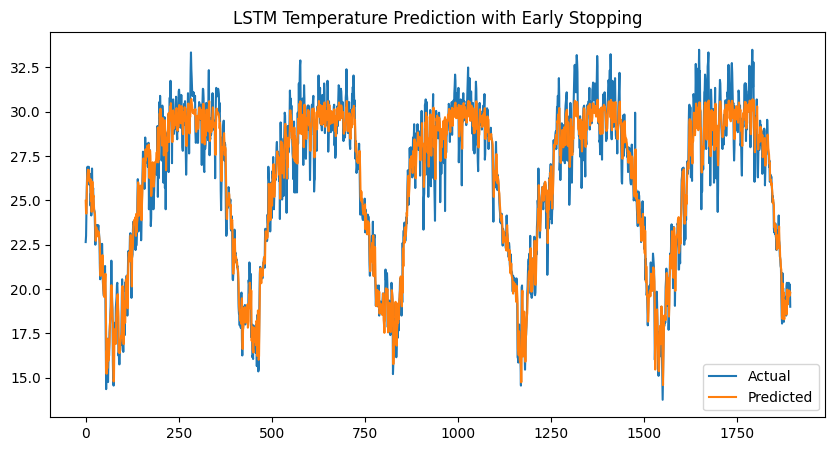

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.title('LSTM Temperature Prediction with Early Stopping')
plt.show()

# Forecasting

In [21]:
# Create future dates from 2025-01-01 to 2034-06-06
start="2025-01-01"
end="2028-12-31"
future_dates = pd.date_range(start=start, end=end, freq="D")

future_df = pd.DataFrame({'Date': future_dates})
future_df['DayOfYear'] = future_df['Date'].dt.dayofyear
future_df['Month'] = future_df['Date'].dt.month
future_df['Year'] = future_df['Date'].dt.year


In [22]:
# Prepare the last 60 rows as the seed sequence

last_60_scaled = x_scaled[-seq_length:]  # already scaled features up to 2024-12-31
last_60_scaled = torch.tensor(last_60_scaled, dtype=torch.float32).unsqueeze(0).to(device)


In [23]:
#  Iteratively forecast

model_0.eval()

predictions_scaled = []

# Start with the last known temp (scaled)
current_sequence = last_60_scaled.clone()


# Extract original min and max for each column from scaler_x
x_min = scaler_x.data_min_
x_max = scaler_x.data_max_

for idx, row in future_df.iterrows():
    # Extract day, month, year
    day_of_year = row['DayOfYear']
    month = row['Month']
    year = row['Year']

    # Get the last predicted temp (scaled) or last actual
    if len(predictions_scaled) == 0:
        # use the last known temp value from training
        last_temp_scaled = current_sequence[0, -1, -1].item()
    else:
        last_temp_scaled = predictions_scaled[-1]

    # Scale day_of_year, month, year using same scaler_x min/max
    def scale_value(value, idx):
        return (value - x_min[idx]) / (x_max[idx] - x_min[idx])

    new_feature_scaled = [
        scale_value(day_of_year, 0),
        scale_value(month, 1),
        scale_value(year, 2),
        last_temp_scaled
    ]

    new_feature_scaled = torch.tensor(new_feature_scaled, dtype=torch.float32).unsqueeze(0).to(device)

    # Update the current sequence (drop the first, append new)
    current_sequence = torch.cat([current_sequence[:, 1:, :], new_feature_scaled.unsqueeze(1)], dim=1)

    # Predict the next temp
    with torch.inference_mode():
        next_pred = model_0(current_sequence)

    predictions_scaled.append(next_pred.cpu().numpy().flatten()[0])


In [24]:
#  Inverse transform predictions

predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Add predictions to the future_df
future_df['PredictedTemp'] = predictions


In [25]:
# Step 5: Extract and print forecasted value for 6 June 2034
specific_date = "2025-08-01"
forecast_value = future_df.loc[future_df["Date"] == specific_date, "PredictedTemp"].values[0]
print(f"Forecasted temperature on {specific_date}: {forecast_value:.2f} °C")


Forecasted temperature on 2025-08-01: 29.85 °C


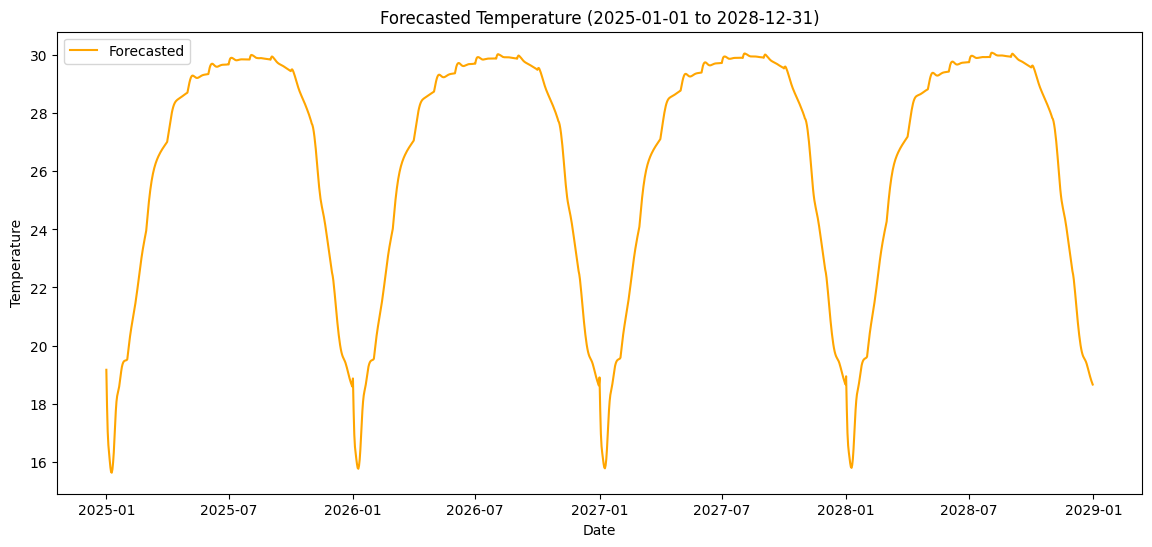

In [26]:
#  Plot future forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(future_df['Date'], future_df['PredictedTemp'], label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title(f'Forecasted Temperature ({start} to {end})')
plt.legend()
plt.show()
